## Get recent tweets from 145 famous investors on Twitter

The Best Invsting Blogs of 2017
https://thecollegeinvestor.com/15601/the-best-investing-blogs/

17 Venture Capital and Angel Investors to Follow on Twitter
https://www.inc.com/larry-kim/17-venture-capital-and-angel-investors-to-follow-on-twitter.html

Nine Twitter Accounts For Aspiring Real Estate Investors To Follow
https://www.forbes.com/sites/forbesrealestatecouncil/2017/05/03/9-twitter-accounts-for-aspiring-real-estate-investors-to-follow/#61c1f6a627a0

10 VCs & Angel Investors to Follow on Twitter
http://www.techinsurance.com/blog/business-tips/10-vcs-angel-investors-to-follow-on-twitter/

These Are The Top 20 Tech Investors You Should Follow On Twitter
http://www.businessinsider.com/top-20-tech-investors-on-twitter-2013-5?op=1

Top 50 Investors on Twitter and How To Engage Them
http://startupfundraising.com/top-50-investors-on-twitter-and-how-to-engage-them/

In [1]:
random_state = 81917

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tweepy
import os

In [ ]:
consumer_key = os.environ["TWITTER_CONSUMER_KEY"]
consumer_secret = os.environ["TWITTER_CONSUMER_SECRET"]
access_token = os.environ["TWITTER_ACCESS_TOKEN"]
access_token_secret = os.environ["TWITTER_TOKEN_SECRET"]

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [ ]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [ ]:
len(user_list)

In [ ]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_collection = investor_tweets_db.tweets_collection

In [ ]:
def get_all_tweets(screen_name):
    '''get all tweets for one user'''
    #initialize a list to hold all the tweepy Tweets
    alltweets = []	

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #print ("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

    print ("{}: {} tweets downloaded so far".format(screen_name, len(alltweets)))
    return alltweets

In [ ]:
for user in user_list[100:]:
    print(user)
    if tweets_collection.find({'user': user}).count() > 0:
        continue
    
    user_twitter = api.get_user(user)
    description = user_twitter.description
    
    all_tweets = get_all_tweets(user)
    all_tweets_raw = []
    for tweet in all_tweets:
        all_tweets_raw.append(tweet.full_text)
    user_dict = {}
    user_dict['user'] = user
    user_dict['all_tweets_raw'] = all_tweets_raw
    user_dict['description'] = description
    tweets_collection.insert_one((user_dict))

In [ ]:
tweets_collection.count()

## Clean Tweets

In [ ]:
import re
import sys
import unicodedata
from string import digits
import html

In [ ]:
for investor in tweets_collection.find({}):
    all_tweets_clean = []
    for tweet in investor['all_tweets_raw']:
        tweet_clean = html.unescape(tweet) #convert html entities to string
        tweet_clean = ''.join(c for c in unicodedata.normalize('NFC', tweet_clean) if c <= '\uFFFF') #remove emojis
        tweet_clean = re.sub('(#[A-Za-z0-9_]+)|(%)|(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)|(^rt)|(^RT)|(^Rt)|(\sRT\s)|(\sRt\s)|(\srt\s)|(http.+?)', ' ', tweet_clean).strip() #remove %, @, https, RT 
        tweet_clean = re.sub('\s+', ' ', tweet_clean) #remove multiple spaces
        tweet_clean = ''.join([i for i in tweet_clean if not i.isdigit()]) #remove all digits
        all_tweets_clean.append(tweet_clean)
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"all_tweets_clean": all_tweets_clean}}) 

In [ ]:
tweets_collection.find({})[0]['bag_of_words']

## Natural Language Processing

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en')

In [ ]:
for investor in tweets_collection.find({}):
    all_tweets_bow = []
    bag_of_words = ''
    for tweet in investor['all_tweets_clean']:
        doc = nlp(tweet)
        bow = ''
        for token in doc:
            if not(token.is_stop or token.is_space or token.is_punct or token.like_num):
                bow += token.lemma_ + ' '
                bag_of_words += token.lemma_ + ' '
        all_tweets_bow.append(bow)
    bag_of_words = re.sub('\s+', ' ', bag_of_words) #remove multiple spaces
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"bag_of_words": bag_of_words}})
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"all_tweets_bow": all_tweets_bow}})

## CountVectorizer

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_collection = investor_tweets_db.tweets_collection

In [4]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [5]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [6]:
corpus = []

In [7]:
for user in user_list:
    corpus.append(tweets_collection.find_one({'user': user})['bag_of_words'])

In [8]:
vectorizer = CountVectorizer(stop_words='english', min_df = 3, max_df = 100)

In [9]:
X = vectorizer.fit_transform(corpus)

In [10]:
X.shape

(143, 25100)

In [11]:
word_list = vectorizer.get_feature_names()

In [12]:
len(word_list)

25100

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

In [14]:
tf = TfidfTransformer()
X_tfidf =  tf.fit_transform(X)

## Functions

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import textwrap
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

In [19]:
from gensim import corpora, models, similarities, matutils

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
def find_who_user_this_word(word):
    word_index = word_list.index(word)
    for i in range(143):
        if(X[i, word_index]) > 0:
            print([user_list[i], X[i, word_index]])

In [22]:
def spectral_Sil_coefs(ns_clusters, X):
    Sil_coefs = []
    for n_clusters in ns_clusters:
        spectral = SpectralClustering(n_clusters=n_clusters, random_state=random_state).fit(X)
        labels = spectral.labels_
        Sil_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    return Sil_coefs

In [23]:
def mean_shift_Sil_coefs(ns_clusters, X):
    Sil_coefs = []
    for n_clusters in ns_clusters:
        ms = MeanShift(bin_seeding=True)
        ms.fit(X)
        labels = ms.labels_
        Sil_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    return Sil_coefs

In [24]:
def agglomerative_Sil_coefs(ns_clusters, X):
    Sil_coefs = []
    for n_clusters in ns_clusters:
        allgomerative = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
        labels = allgomerative.labels_
        Sil_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    return Sil_coefs

In [25]:
def kmeans_inertias(ns_clusters, X):
    inertias = []
    for n_clusters in ns_clusters:
        kmeans = KMeans(n_clusters=n_clusters , random_state=random_state).fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

In [26]:
def kmeans_Sil_coefs(ns_clusters, X):
    Sil_coefs = []
    for n_clusters in ns_clusters:
        kmeans = KMeans(n_clusters=n_clusters , random_state=random_state).fit(X)
        labels = kmeans.labels_
        Sil_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    return Sil_coefs

In [27]:
def make_user_cluster_dataframe(pred_cluster):
    user_cluster = pd.DataFrame(columns=['user', 'cluster', 'description'])
    for index, user in enumerate(user_list):
        description = tweets_collection.find({'user': user})[0]['description']
        user_cluster = user_cluster.append(pd.DataFrame([[user, pred_cluster[index], description]], columns = ['user', 'cluster', 'description']))
    return user_cluster

In [28]:
def make_hover_text(pred_cluster, user_list):
    hover_text = []
    for index, user in enumerate(user_list):
        investor = tweets_collection.find({'user': user})[0]
        cluster = pred_cluster[index]
        description = '<br>'.join(textwrap.wrap(investor['description'], 50))
        hover_text.append(('Cluster: {cluster}<br>'+
                          'Name: {name}<br>'+
                          'Description: {description}<br>').format(cluster=cluster,
                                                name=user,
                                                description=description))
    return hover_text

In [29]:
def plot_3D(X, hover_text, cluster):
    trace1 = go.Scatter3d(
        x=X[:,0],
        y=X[:,1],
        z=X[:,2],
        mode='markers',
        marker=dict(
            size=12,
            color=cluster,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
        text=hover_text,

        hoverinfo='text'
    )

    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    return data, layout

## Gensim LDA Preparation

In [30]:
corpus_gensim_lda = matutils.Sparse2Corpus(X.transpose())

In [31]:
type(corpus_gensim_lda)

gensim.matutils.Sparse2Corpus

In [32]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [33]:
len(id2word)

25100

## LDA and Clustering Models

In [30]:
ns_topics = np.arange(3, 11, 1)
ns_clusters = np.arange(2, 20, 1)

In [38]:
all_kmeans_inertias = []
all_kmeans_Sil_coefs = []
all_spectral_Sil_coefs = []
all_meanshift_Sil_coefs = []
all_agglomerative_Sil_coefs = []
ldas = []
for n_topics in ns_topics:
    lda = models.LdaModel(corpus=corpus_gensim_lda, 
                      num_topics=n_topics, 
                      id2word=id2word, 
                      passes=30)
    ldas.append(lda)
    lda.print_topics()
#     lda_corpus = lda[corpus_gensim_lda]
#     lda_docs = [doc for doc in lda_corpus]
#     investor_topic = np.zeros(shape=(143, 3))
#     for index, doc in enumerate(lda_docs):
#         for topic in doc:
#             if topic[0] == 0:
#                 investor_topic[index][0] = topic[1]
#             elif topic[0] == 1:
#                 investor_topic[index][1] = topic[1]
#             elif topic[0] == 2:
#                 investor_topic[index][2] = topic[1]
#             else:
#                 continue
#     all_kmeans_inertias.append(kmeans_inertias(ns_clusters, investor_topic))
#     all_kmeans_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, investor_topic))
#     all_spectral_Sil_coefs.append(spectral_Sil_coefs(ns_clusters, investor_topic))
#     all_meanshift_Sil_coefs.append(mean_shift_Sil_coefs(ns_clusters, investor_topic))
#     all_agglomerative_Sil_coefs.append(agglomerative_Sil_coefs(ns_clusters, investor_topic))

In [ ]:
# import pickle
# pickle.dump(ldas, open('ldas.p', 'wb'))

In [28]:
import pickle

In [31]:
ldas = pickle.load(open('ldas.p', 'rb'))

In [17]:
ldas[3].print_topics()

[(0,
  '0.032*"estate" + 0.014*"property" + 0.011*"tenant" + 0.010*"landlord" + 0.009*"texas" + 0.009*"rental" + 0.008*"housing" + 0.006*"rec" + 0.006*"rent" + 0.005*"mish"'),
 (1,
  '0.007*"bond" + 0.007*"blackstone" + 0.007*"fx" + 0.006*"eu" + 0.006*"yield" + 0.006*"fed" + 0.006*"european" + 0.005*"brexit" + 0.005*"usd" + 0.004*"inflation"'),
 (2,
  '0.027*"spy" + 0.020*"spx" + 0.008*"trading" + 0.008*"vix" + 0.007*"fed" + 0.007*"prev" + 0.006*"aapl" + 0.006*"bull" + 0.005*"bullish" + 0.005*"earning"'),
 (3,
  '0.006*"entrepreneur" + 0.003*"cat" + 0.002*"amzn" + 0.002*"wonderful" + 0.002*"wmt" + 0.002*"hug" + 0.002*"jelly" + 0.002*"tree" + 0.002*"bitcoin" + 0.002*"subscribe"'),
 (4,
  '0.007*"vc" + 0.006*"entrepreneur" + 0.003*"venture" + 0.003*"boston" + 0.002*"valley" + 0.002*"unicorn" + 0.002*"silicon" + 0.002*"thx" + 0.002*"software" + 0.002*"sf"'),
 (5,
  '0.005*"climate" + 0.004*"russia" + 0.003*"gop" + 0.003*"donald" + 0.003*"fake" + 0.003*"russian" + 0.003*"yeah" + 0.002*"cli

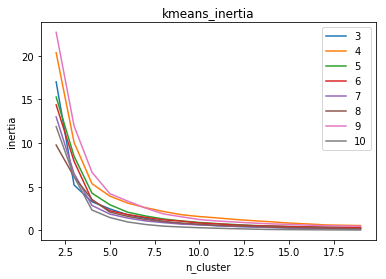

In [159]:
n = 3
for inertias in all_kmeans_inertias:
    plt.plot(ns_clusters, inertias, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('inertia')
plt.title('kmeans_inertia');

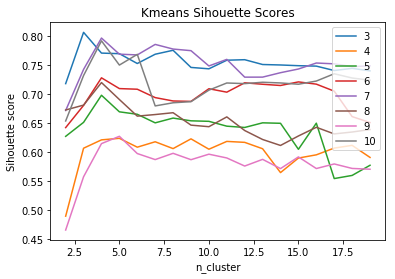

In [160]:
n = 3
for Sil_coefs in all_kmeans_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Kmeans Sihouette Scores');

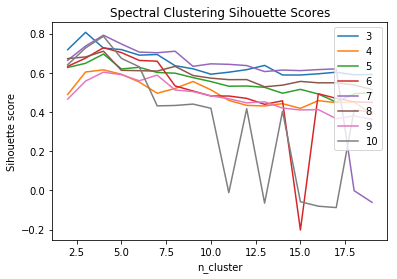

In [161]:
n = 3
for Sil_coefs in all_spectral_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Spectral Clustering Sihouette Scores');

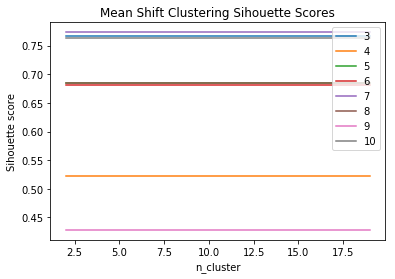

In [162]:
n = 3
for Sil_coefs in all_meanshift_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Mean Shift Clustering Sihouette Scores');

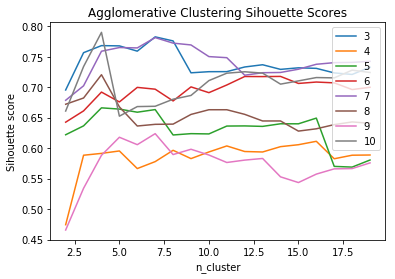

In [163]:
n = 3
for Sil_coefs in all_agglomerative_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Agglomerative Clustering Sihouette Scores');

## Final Results

In [105]:
#lda = models.LdaModel(corpus=corpus_gensim_lda, 
#                       num_topics=num_topics, 
#                       id2word=id2word, 
#                       passes=30)

In [104]:
num_topics = 6

In [106]:
import pickle
ldas = pickle.load(open('ldas.p', 'rb'))
lda = ldas[num_topics-3]

In [107]:
lda.print_topics()

[(0,
  '0.032*"estate" + 0.014*"property" + 0.011*"tenant" + 0.010*"landlord" + 0.009*"texas" + 0.009*"rental" + 0.008*"housing" + 0.006*"rec" + 0.006*"rent" + 0.005*"mish"'),
 (1,
  '0.007*"bond" + 0.007*"blackstone" + 0.007*"fx" + 0.006*"eu" + 0.006*"yield" + 0.006*"fed" + 0.006*"european" + 0.005*"brexit" + 0.005*"usd" + 0.004*"inflation"'),
 (2,
  '0.027*"spy" + 0.020*"spx" + 0.008*"trading" + 0.008*"vix" + 0.007*"fed" + 0.007*"prev" + 0.006*"aapl" + 0.006*"bull" + 0.005*"bullish" + 0.005*"earning"'),
 (3,
  '0.006*"entrepreneur" + 0.003*"cat" + 0.002*"amzn" + 0.002*"wonderful" + 0.002*"wmt" + 0.002*"hug" + 0.002*"jelly" + 0.002*"tree" + 0.002*"bitcoin" + 0.002*"subscribe"'),
 (4,
  '0.007*"vc" + 0.006*"entrepreneur" + 0.003*"venture" + 0.003*"boston" + 0.002*"valley" + 0.002*"unicorn" + 0.002*"silicon" + 0.002*"thx" + 0.002*"software" + 0.002*"sf"'),
 (5,
  '0.005*"climate" + 0.004*"russia" + 0.003*"gop" + 0.003*"donald" + 0.003*"fake" + 0.003*"russian" + 0.003*"yeah" + 0.002*"cli

In [108]:
lda_corpus = lda[corpus_gensim_lda]
lda_docs = [doc for doc in lda_corpus]

In [166]:
investor_topic = np.zeros(shape=(143, num_topics))

In [170]:
for index, doc in enumerate(lda_docs):
    for topic in doc:
        investor_topic[index][topic[0]] = topic[1]

In [172]:
ns = np.arange(2, 20, 1)

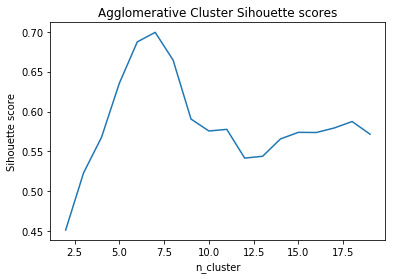

In [173]:
plt.plot(ns, agglomerative_Sil_coefs(ns, investor_topic))
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Agglomerative Cluster Sihouette scores');

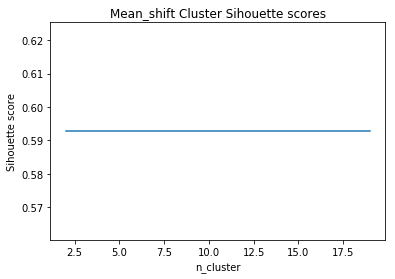

In [174]:
plt.plot(ns, mean_shift_Sil_coefs(ns, investor_topic))
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Mean_shift Cluster Sihouette scores');

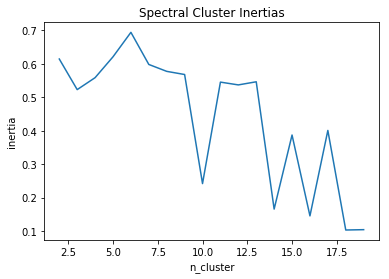

In [175]:
plt.plot(ns, spectral_Sil_coefs(ns, investor_topic))
plt.xlabel('n_cluster')
plt.ylabel('inertia')
plt.title('Spectral Cluster Inertias');

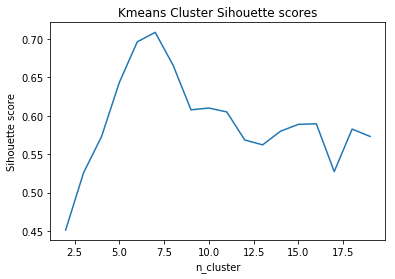

In [177]:
plt.plot(ns, kmeans_Sil_coefs(ns, investor_topic))
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Kmeans Cluster Sihouette scores');

In [384]:
n_cluster = 6
kmeans = KMeans(n_clusters=n_cluster, random_state=random_state).fit(investor_topic)

In [385]:
centroids = kmeans.cluster_centers_ 

In [386]:
for centroid in centroids:
    print(centroid)

[ 0.00528235  0.05198486  0.77275794  0.01071841  0.0991094   0.06459678]
[ 0.00112011  0.01055144  0.00112011  0.03308654  0.89393246  0.06040997]
[ 0.01182516  0.72229627  0.08932035  0.01330706  0.04594213  0.12815632]
[ 0.93299475  0.82776969  0.90881333  0.93299475  0.83249924  0.93299475]
[ 0.02138229  0.05090364  0.08672214  0.06078497  0.12811134  0.71244134]
[  1.38777878e-17   2.77555756e-17   1.39640121e-02   9.55094629e-01
   2.04822548e-02   9.83395649e-03]


In [387]:
pred_cluster = kmeans.fit_predict(investor_topic)

In [388]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [389]:
from collections import Counter

In [390]:
Counter(pred_cluster)

Counter({0: 18, 1: 66, 2: 23, 3: 8, 4: 21, 5: 7})

In [541]:
user_cluster[user_cluster.cluster == 0]

,user,cluster,description
0,_seandavid,0,Founder & CIO of @AvoryCo | Finding growth and...
0,andrewnyquist,0,Founder of @seeitmarket. Active Investor. Spor...
0,annemarietrades,0,"Believer. Fire breathing trader, and trading ..."
0,callieabost,0,"NC-based analyst, market-watcher, fmr @TABBGro..."
0,ciovaccocapital,0,Founder & CEO Ciovacco Capital Management. Pro...
0,faithmight,0,Investor. Trader. Co-founder @FMCapitalGrp. Bo...
0,hmeisler,0,I write a daily column for http://t.co/sGTJX6Y...
0,jlyonsfundmgmt,0,"Editor, The Lyons Share●Partner, JLFMI RIA htt..."
0,joelkruger,0,💱Currency trader. Founder @JKonFX. FX strategi...
0,klcapital,0,Knowledge Leaders Capital. Indexes + Funds + B...


## Word Cloud

In [197]:
from wordcloud import WordCloud

In [371]:
for user in user_list:
    investor = tweets_collection.find_one({'user': user})
    s = ''
    for word in investor['bag_of_words'].split():
        if word in vectorizer.vocabulary_:
            s = s + ' ' + word
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"pretty_bow": s}}) 

In [377]:
cluster = 1

In [379]:
pretty_bows = []
for cluster in range(n_cluster):
    s = ''
    for user in user_cluster[user_cluster.cluster == cluster].user:
        s = s + ' ' + tweets_collection.find_one({'user': user})['pretty_bow']
    pretty_bows.append(s)  

In [425]:
# lower max_font_size
def make_word_cloud(pretty_bow, mask):
    from PIL import Image
    cloud_mask = np.array(Image.open(mask))

    wordcloud = WordCloud(
        font_path='cabin-sketch-bold.ttf',
        #width = 1200, 
        #height=800, 
        mask = cloud_mask, 
        background_color = 'white', 
        min_font_size=1, 
        max_font_size=200, 
        max_words=2000,
        colormap='brg').generate(pretty_bow)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();

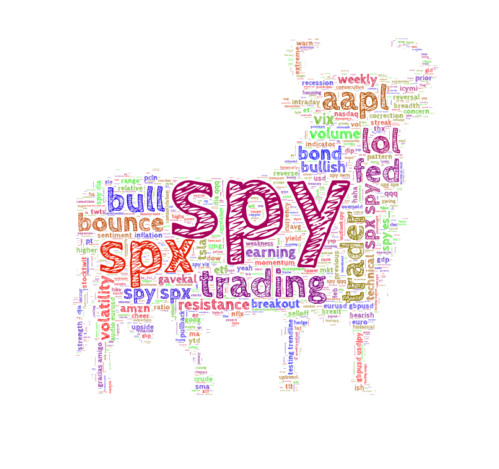

In [435]:
make_word_cloud(pretty_bows[0],'bull.jpg')

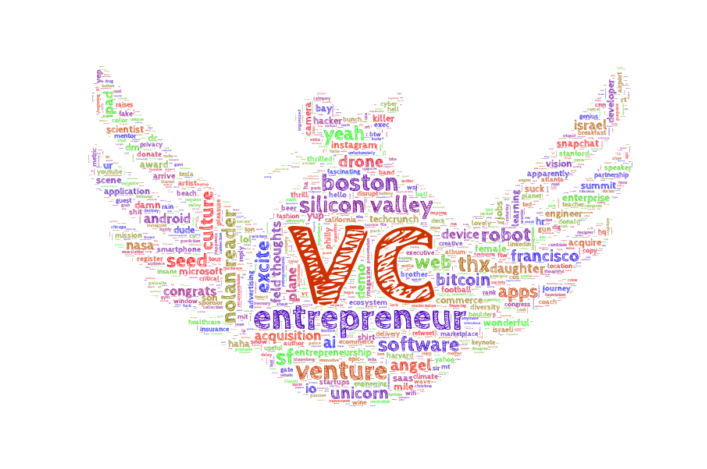

In [448]:
make_word_cloud(pretty_bows[1],'angel.png')

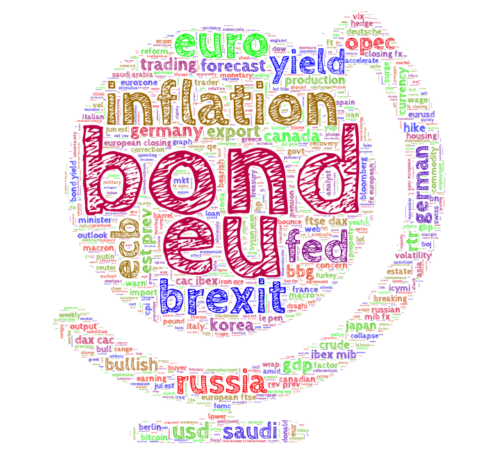

In [429]:
make_word_cloud(pretty_bows[2],'globe.jpg')

In [496]:
user_cluster[user_cluster.cluster == 3]

,user,cluster,description
0,andybiotech,3,#Biotech Investor | Recovering Scientist | May...
0,jbrec,3,We are a leading U.S. real estate research fir...
0,joefairless,3,Host of Best Real Estate Investing Advice Ever...
0,landlordology,3,Resources for Landlords and Property Managers....
0,marketminute,3,(Mish) Dir. of Trading Education & Research fo...
0,mitch_stephen,3,"Forbes named Mitch in the ""Top 9 Twitter Accou..."
0,retipsterseth,3,Founder of https://t.co/z539rj7uRQ. Real World...
0,texrec,3,Real Estate Center at Texas A&amp;M University


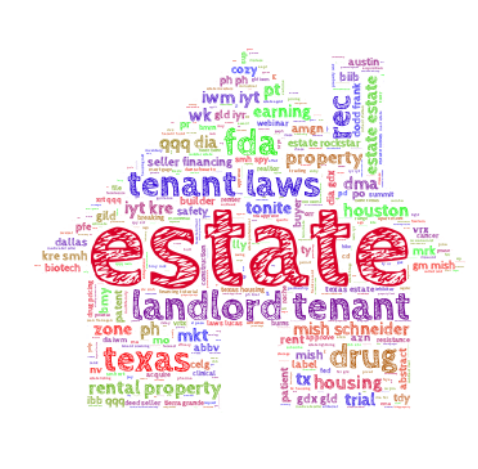

In [437]:
make_word_cloud(pretty_bows[3],'house.jpg')

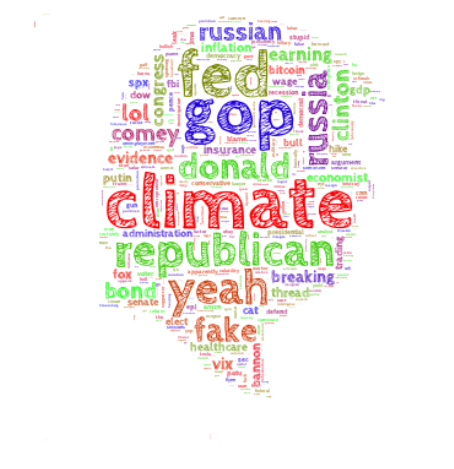

In [426]:
make_word_cloud(pretty_bows[4],'trump.jpg')

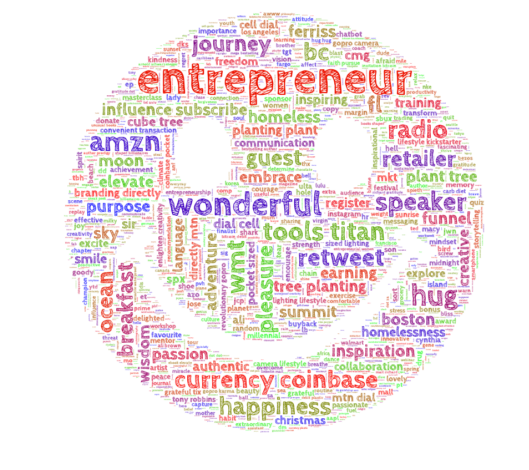

In [444]:
make_word_cloud(pretty_bows[5],'smilely_face.png')

## 3D Visualization

In [451]:
import pickle
ldas = pickle.load(open('ldas.p', 'rb'))
lda_3 = ldas[0]

In [453]:
lda_3.print_topics()

[(0,
  '0.012*"estate" + 0.006*"property" + 0.004*"housing" + 0.004*"texas" + 0.003*"unicorn" + 0.003*"fx" + 0.003*"russia" + 0.003*"closing" + 0.003*"rental" + 0.002*"european"'),
 (1,
  '0.006*"vc" + 0.006*"entrepreneur" + 0.003*"venture" + 0.002*"blackstone" + 0.002*"boston" + 0.002*"valley" + 0.002*"thx" + 0.002*"silicon" + 0.002*"software" + 0.002*"sf"'),
 (2,
  '0.013*"spy" + 0.010*"spx" + 0.007*"fed" + 0.007*"bond" + 0.005*"yield" + 0.005*"trading" + 0.004*"vix" + 0.004*"prev" + 0.004*"earning" + 0.003*"bullish"')]

In [459]:
lda_3_corpus = lda_3[corpus_gensim_lda]
lda_3_docs = [doc for doc in lda_3_corpus]

In [460]:
investor_topic_3 = np.zeros(shape=(143, 3))

In [535]:
lda_3.show_topics(formatted=False)

[(0,
  [('estate', 0.012273809758674202),
   ('property', 0.0055107333347855607),
   ('housing', 0.0039171410206726787),
   ('texas', 0.0036453214859744907),
   ('unicorn', 0.0031932363156621651),
   ('fx', 0.0031211569057635314),
   ('russia', 0.002951119485210331),
   ('closing', 0.0026294605016185415),
   ('rental', 0.0025966341349364023),
   ('european', 0.0024827251147131494)]),
 (1,
  [('vc', 0.0055678879655388629),
   ('entrepreneur', 0.0055153138861327791),
   ('venture', 0.0025886668895947671),
   ('blackstone', 0.0024560838143020472),
   ('boston', 0.0024144626504403965),
   ('valley', 0.0019772694043969064),
   ('thx', 0.0017252374306643335),
   ('silicon', 0.0017041773621583763),
   ('software', 0.0016282543303393199),
   ('sf', 0.0015729641623102013)]),
 (2,
  [('spy', 0.012734677822620352),
   ('spx', 0.0095166435436638518),
   ('fed', 0.0067948064716418189),
   ('bond', 0.0065199042795441647),
   ('yield', 0.0049694573601534297),
   ('trading', 0.0047907557344519626),
  

In [462]:
for index, doc in enumerate(lda_3_docs):
    for topic in doc:
        investor_topic_3[index][topic[0]] = topic[1]

In [463]:
ns = np.arange(2, 20, 1)

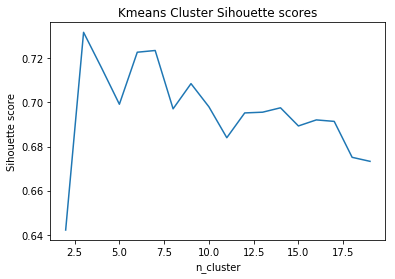

In [473]:
plt.plot(ns, kmeans_Sil_coefs(ns, investor_topic_3))
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score')
plt.title('Kmeans Cluster Sihouette scores');

In [481]:
n_cluster = 7
kmeans = KMeans(n_clusters=n_cluster, random_state=random_state).fit(investor_topic)

In [482]:
centroids = kmeans.cluster_centers_ 

In [483]:
for centroid in centroids:
    print(centroid)

[ 0.00112011  0.01055144  0.00112011  0.03308654  0.89393246  0.06040997]
[ 0.01182516  0.72229627  0.08932035  0.01330706  0.04594213  0.12815632]
[ 0.99809361  0.99809361  0.99809361  0.99809361  0.99809361  0.99809361]
[ 0.00136408  0.04351781  0.0725472   0.0427369   0.11342959  0.72697609]
[ 0.00528235  0.05198486  0.77275794  0.01071841  0.0991094   0.06459678]
[ 0.63238087  0.27740534  0.55072198  0.63238087  0.36439285  0.63238087]
[  1.38777878e-17   2.77555756e-17   1.39640121e-02   9.55094629e-01
   2.04822548e-02   9.83395649e-03]


In [484]:
pred_cluster_3 = kmeans.fit_predict(investor_topic_3)

In [485]:
user_cluster_3 = make_user_cluster_dataframe(pred_cluster_3)

In [486]:
from collections import Counter

In [487]:
Counter(pred_cluster_3)

Counter({0: 14, 1: 68, 2: 14, 3: 21, 4: 8, 5: 13, 6: 5})

In [488]:
hover_text = make_hover_text(pred_cluster=pred_cluster_3, user_list = user_list)

In [489]:
data, layout = plot_3D(investor_topic_3, hover_text, user_cluster_3.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tongwu21/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


In [539]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Bar(
    x=['Inv 1', 'Inv 2', 'Inv 3'],
    y=[0.9, 0.1, 0.05],
    name='Topic 1',
    marker=dict(
        color='rgb(77,118,164)'
    )
)
trace1 = go.Bar(
    x=['Inv 1', 'Inv 2', 'Inv 3'],
    y=[0.05, 0.8, 0.1],
    name='Topic 2',
    marker=dict(
        color='rgb(95,132,76)',
    )
)
trace2 = go.Bar(
    x=['Inv 1', 'Inv 2', 'Inv 3'],
    y=[0.05, 0.1, 0.85],
    name='Topic 3',
    marker=dict(
        color='rgb(193,94,23)',
    )
)

data = [trace0, trace1, trace2]
layout = go.Layout(
    xaxis=dict(tickangle=0),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

## sklearn - LDA

In [ ]:
ns_topics = np.arange(3, 10, 1)
ns_clusters = np.arange(3, 15, 1)

In [ ]:
all_inertias = []
all_Sil_coefs = []
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X)
    H = lda_model.components_
    all_inertias.append(kmeans_inertias(ns_clusters, W))
    all_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, W))

In [ ]:
n = 3
for inertias in all_inertias:
    plt.plot(ns_clusters, inertias, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
n = 3
for Sil_coefs in all_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n_topics = 3
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=20, learning_method='online',                
                                learning_offset=20, random_state=random_state)

In [ ]:
topic_word_matrix = lda_model.fit_transform(X.transpose())

In [ ]:
topic_word_matrix = topic_word_matrix.transpose()

In [ ]:
investor_topic_matrix = lda_model.components_.transpose()

In [ ]:
investor_topic_matrix.shape

In [ ]:
topic_word_matrix.shape

In [ ]:
words_in_topics = []
for i in range(n_topics):
    topic = topic_word_matrix[i, :]
    importance = -np.sort(-topic)[:10]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

In [ ]:
n = 6
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(investor_topic_matrix)

In [ ]:
pred_cluster = kmeans.fit_predict(investor_topic_matrix)

In [ ]:
from collections import Counter
Counter(pred_cluster)

In [ ]:
user_cluster_df = make_user_cluster_dataframe(pred_cluster)

In [ ]:
user_cluster_df.sort_values('cluster')

In [ ]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)
data, layout = plot_3D(investor_topic_matrix, hover_text, user_cluster_df.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

## NF-IDF SVD

In [ ]:
svd = TruncatedSVD(n_components=200, n_iter=50, random_state=random_state)
svd.fit(X_tfidf)
X_reduced = svd.transform(X_tfidf)

In [ ]:
explained_variance_ratio = svd.explained_variance_ratio_

In [ ]:
sum_ratio = 0
for index, ratio in enumerate(explained_variance_ratio):
    sum_ratio += ratio
    if sum_ratio > 0.95:
        print(index)
        break

In [ ]:
X_reduced

In [ ]:
ns_clusters = np.arange(2, 20, 1)

In [ ]:
inertias = kmeans_inertias(ns_clusters, X_reduced_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, X_reduced_3)

In [ ]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n = 7
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X_reduced)

In [ ]:
pred_cluster = kmeans.fit_predict(X_reduced)

In [ ]:
Counter(pred_cluster)

In [ ]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [ ]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', 150)

In [ ]:
user_cluster.sort_values('cluster')

## TFIDF - LDA

In [ ]:
n_topics = 3
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)

In [ ]:
W = lda_model.fit_transform(X_tfidf.transpose())

In [ ]:
topic_word_matrix = W.transpose()

In [ ]:
investor_topic_matrix = lda_model.components_.transpose()

In [ ]:
investor_topic_matrix.shape

In [ ]:
words_in_topics = []
for i in range(n_topics):
    topic = topic_word_matrix[i, :]
    importance = -np.sort(-topic)[:10]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

In [ ]:
word_index = word_list.index('nolan')
for i in range(143):
    if(X[i, word_index]) > 0:
        print([user_list[i], X[i, word_index]])

In [ ]:
ns_clusters = np.arange(2, 20, 1)

In [ ]:
inertias = kmeans_inertias(ns_clusters, investor_topic_matrix) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, investor_topic_matrix)

In [ ]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n = 5
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(investor_topic_matrix)

In [ ]:
pred_cluster = kmeans.fit_predict(investor_topic_matrix)

In [ ]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [ ]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [ ]:
from collections import Counter

In [ ]:
Counter(pred_cluster)

In [ ]:
data, layout = plot_3D(investor_topic_matrix, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
ns_topics = np.arange(3, 10, 1)
ns_clusters = np.arange(3, 15, 1)

In [ ]:
all_inertias = []
all_Sil_coefs = []
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X_tfidf)
    H = lda_model.components_
    all_inertias.append(kmeans_inertias(ns_clusters, W))
    all_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, W))

In [ ]:
n = 3
for inertias in all_inertias:
    plt.plot(ns_clusters, inertias, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
n = 3
for Sil_coefs in all_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
def find_words_in_topics_tfidf(n_topics):
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X_tfidf)
    H = lda_model.components_
    words_in_topics = []
    for i in range(n_topics):
        topic = H[:, i]
        importance = -np.sort(-topic)[:10]
        word_indices = (-topic).argsort()[:10]
        #print([word_list[word_index] for word_index in word_indices])
        #print(importance)
        words_in_topics.append([word_list[word_index] for word_index in word_indices])
    return words_in_topics

In [ ]:
# ns_topics = np.arange(3, 11, 1)
# words_in_topics_for_n_topics = []
# for n_topics in ns_topics:
#     print('{} topics:'.format(n_topics))
#     words_in_topics = find_words_in_topics_tfidf(n_topics)
#     words_in_topics_for_n_topics.append(words_in_topics)
#     for words_in_topic in words_in_topics:
#         print(words_in_topic)

## SVD

In [ ]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=random_state)
svd.fit(X)
X_reduced = svd.transform(X)

In [ ]:
explained_variance_ratio = svd.explained_variance_ratio_

In [ ]:
sum_ratio = 0
for index, ratio in enumerate(explained_variance_ratio):
    sum_ratio += ratio
    if sum_ratio > 0.95:
        print(index)
        break

In [ ]:
svd_3 = TruncatedSVD(n_components=3, n_iter=7, random_state=random_state)
svd_3.fit(X)
X_reduced_3 = svd_3.transform(X)
print(svd_3.explained_variance_ratio_) 

In [ ]:
components = svd_3.components_

In [ ]:
components.shape

In [ ]:
words_in_component = []
for component in components:
    word_indices = (-component).argsort()[:10]
    words_in_component.append([word_list[word_index] for word_index in word_indices])

In [ ]:
for component in words_in_component:
    print(component)

In [ ]:
distinct_words_in_component = []
for index, wic in enumerate(words_in_component):
    other_components_union_1 = set().union(*words_in_component[0:index])
    other_components_union_2 = set().union(*words_in_component[(index+1):])
    other_components_union = other_components_union_1.union(other_components_union_2)
    distinct_words_in_component.append(set(wic).difference(other_components_union))

In [ ]:
print(distinct_words_in_component)

In [ ]:
print(np.sum(svd_3.explained_variance_ratio_))

In [ ]:
ns_clusters = np.arange(2, 20, 1)

In [ ]:
inertias = kmeans_inertias(ns_clusters, X_reduced_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, X_reduced_3)

In [ ]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n = 6
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X_reduced_3)

In [ ]:
pred_cluster = kmeans.fit_predict(X_reduced_3)

In [ ]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [ ]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [ ]:
data, layout = plot_3D(X_reduced_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

## NMF

In [ ]:
X.shape

In [ ]:
n_components = 3

In [ ]:
nmf_model = NMF(n_components=n_components, init='random', random_state=random_state)
W_3 = nmf_model.fit_transform(X.transpose());
H_3 = nmf_model.components_;

In [ ]:
W_3.shape

In [ ]:
H_3.shape

In [ ]:
X_nmf_3 = H_3.transpose()

In [ ]:
words_in_topics = []
for i in range(n_components):
    topic = W_3[:, i]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

In [ ]:
print(H_3[:, 0])

In [ ]:
ns_clusters = np.arange(2, 20, 1)

In [ ]:
inertias = kmeans_inertias(ns_clusters, X_nmf_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, X_nmf_3)

In [ ]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X_nmf_3)

In [ ]:
pred_cluster = kmeans.fit_predict(X_nmf_3)

In [ ]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [ ]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [ ]:
data, layout = plot_3D(X_nmf_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

## LDA

In [ ]:
X.shape

In [ ]:
n_topics = 3
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)

In [ ]:
W = lda_model.fit_transform(X.transpose());

In [ ]:
H = lda_model.components_;

In [ ]:
W.shape

In [ ]:
H.shape

In [ ]:
H_lda_3 = H.transpose()

In [ ]:
ns_clusters = np.arange(2, 20, 1)

In [ ]:
inertias = kmeans_inertias(ns_clusters, H_lda_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, H_lda_3)

In [ ]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [ ]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(H_lda_3)

In [ ]:
pred_cluster = kmeans.fit_predict(H_lda_3)

In [ ]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [ ]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [ ]:
words_in_topics = []
for i in range(n_topics):
    topic = W[:, i]
    importance = -np.sort(-topic)[:10]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

In [ ]:
data, layout = plot_3D(H_lda_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
ns_topics = np.arange(3, 30, 3)
ns_clusters = np.arange(4, 15, 1)

In [ ]:
all_inertias = []
all_Sil_coefs = []
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X.transpose())
    H = lda_model.components_
    all_inertias.append(kmeans_inertias(ns_clusters, H.transpose()))
    all_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, H.transpose()))

In [ ]:
# n = 3
# for inertias in all_inertias:
#     plt.plot(ns_clusters, inertias, label = str(n))
#     n += 3
# plt.legend(loc='upper right')
# plt.xlabel('n_cluster')
# plt.ylabel('inertia');

In [ ]:
# n = 3
# for Sil_coefs in all_Sil_coefs:
#     plt.plot(ns_clusters, Sil_coefs, label = str(n))
#     n += 3
# plt.legend(loc='upper right')
# plt.xlabel('n_cluster')
# plt.ylabel('Sihouette score');

In [ ]:
def find_words_in_topics(n_topics):
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X.transpose())
    H = lda_model.components_
    words_in_topics = []
    for i in range(n_topics):
        topic = W[:, i]
        importance = -np.sort(-topic)[:10]
        word_indices = (-topic).argsort()[:10]
        #print([word_list[word_index] for word_index in word_indices])
        #print(importance)
        words_in_topics.append([word_list[word_index] for word_index in word_indices])
    return words_in_topics

In [ ]:
ns_topics = np.arange(3, 11, 1)
words_in_topics_for_n_topics = []
for n_topics in ns_topics:
    print('{} topics:'.format(n_topics))
    words_in_topics = find_words_in_topics(n_topics)
    words_in_topics_for_n_topics.append(words_in_topics)
    for words_in_topic in words_in_topics:
        print(words_in_topic)

In [ ]:
word_index = word_list.index('adcom')
for i in range(143):
    if(X[i, word_index]) > 0:
        print([user_list[i], X[i, word_index]])

In [ ]:
# topic_word_user_count = []
# for row in words_in_topics:
#     for word in row:
#         temp = {word: []}
#         word_index = word_list.index(word)
#         for i in range(143):
#             if(X[i, word_index]) > 0:
#                 temp[word].append([user_list[i], X[i, word_index]])
#         topic_word_user_count.append(temp)

In [ ]:
# # find out who has used the top words in each topic
# for item in topic_word_user_count:
#     print(item) 